In [1]:
from datetime import datetime, timezone, timedelta
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from helpers import util
import os

In [2]:
today = datetime.now(timezone.utc).replace(tzinfo=None)
today

datetime.datetime(2025, 11, 15, 11, 26, 38, 675762)

In [3]:
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
sensors_str = secrets.get_secret("SENSORS_JSON").value
sensors_data = json.loads(sensors_str)

2025-11-15 12:26:38,705 INFO: Initializing external client
2025-11-15 12:26:38,708 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-15 12:26:39,344 WARNING: UserWarning: The installed hopsworks client version 4.1.4 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-15 12:26:40,297 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1272014


In [4]:
mr = project.get_model_registry()

retrieved_model_base = mr.get_model(
    name="air_quality_xgboost_base_model",
    version=1,
)
retrieved_model_lagged = mr.get_model(
    name="air_quality_xgboost_lagged_model",
    version=1,
)

# Download the saved models artifacts to a local directory
saved_model_dir_base = retrieved_model_base.download()
saved_model_dir_lagged = retrieved_model_lagged.download()

In [5]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model_base = XGBRegressor()
retrieved_xgboost_model_base.load_model(saved_model_dir_base + "/model.json")
retrieved_xgboost_model_lagged = XGBRegressor()
retrieved_xgboost_model_lagged.load_model(saved_model_dir_lagged + "/model.json")

In [6]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)

yesterday_2359 = (today - timedelta(days=1)).replace(hour=23, minute=59, second=59, microsecond=0)
air_quality_data = air_quality_fg.filter(air_quality_fg.date >= yesterday_2359.date()).read().drop(columns="url")
weather_data = weather_fg.filter(weather_fg.date >= today).read().sort_values(by='date')

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.63s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.62s) 


In [7]:
weather_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2025-11-16 00:00:00+00:00,3.20,0.0,6.489992,236.309906,årjäng
1,2025-11-16 00:00:00+00:00,3.20,0.0,3.600000,270.000000,skoghall
2,2025-11-16 00:00:00+00:00,2.30,0.0,5.014219,248.962418,jonsbyn
3,2025-11-16 00:00:00+00:00,2.30,0.0,6.638072,257.471191,nykroppa
4,2025-11-17 00:00:00+00:00,0.60,0.0,17.651016,348.231720,årjäng
5,2025-11-17 00:00:00+00:00,0.05,0.0,11.792404,347.660919,jonsbyn
6,2025-11-17 00:00:00+00:00,0.80,0.0,13.779114,340.144684,skoghall
7,2025-11-17 00:00:00+00:00,0.15,0.0,10.483357,344.054535,nykroppa
10,2025-11-18 00:00:00+00:00,0.20,0.0,1.297998,213.690094,nykroppa
11,2025-11-18 00:00:00+00:00,0.80,0.0,1.800000,36.869991,årjäng


In [8]:
air_quality_data

,date,pm25,lagged_1,lagged_2,lagged_3,country,city,street
0,2025-11-15 00:00:00+00:00,10.0,3.0,5.0,33.978001,sweden,skoghall,folkungavägen
1,2025-11-15 00:00:00+00:00,3.0,2.0,3.0,14.700000,sweden,årjäng,strand
2,2025-11-15 00:00:00+00:00,2.0,2.0,6.0,4.620000,sweden,jonsbyn,acksjön
3,2025-11-15 00:00:00+00:00,4.0,5.0,7.0,24.444000,sweden,nykroppa,timmersvägen


In [9]:
def prepare_prediction_row(row, air_quality_data, lagged_available):
    # Ensure air_quality_data['date'] is datetime
    air_quality_data['date'] = pd.to_datetime(air_quality_data['date'])
    
    # Initialize dictionary for features
    features = {}
    city = row['city']
    pred_date = pd.to_datetime(row['date'])
    prev_date = pred_date - pd.Timedelta(days=1)

    # filter the air quality data
    last_days_aq = air_quality_data[
        (air_quality_data['city'] == city) &
        (air_quality_data['date'].dt.date == prev_date.date())
    ]

    if lagged_available:
        features['lagged_3'] = last_days_aq['lagged_2'].item()
        features['lagged_2'] = last_days_aq['lagged_1'].item()
        features['lagged_1'] = last_days_aq['predicted_pm25'].item()
    features['city'] = city
    features['street'] = last_days_aq['street'].item()
    features['country'] = last_days_aq['country'].item()
    features['date'] = pred_date
    
    # Copy weather features
    weather_cols = ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']
    for col in weather_cols:
        features[col] = row[col]
    
    # Convert to single-row DataFrame
    prediction_df = pd.DataFrame([features])
    prediction_df['city'] = prediction_df['city'].astype('category')
    
    return prediction_df

In [10]:
def append_predicted_pm25(air_quality_data, prediction_row, predicted_pm25, lagged_available):
    new_row = prediction_row
    new_row["predicted_pm25"] = predicted_pm25
    if lagged_available:
        new_row['lagged_1'] = prediction_row['lagged_1']
        new_row['lagged_2'] = prediction_row['lagged_2']
        new_row['lagged_3'] = prediction_row['lagged_3']
    
    # Append new row to DataFrame
    updated_air_quality_data = pd.concat([air_quality_data, pd.DataFrame(new_row)], ignore_index=True)
    return updated_air_quality_data

In [11]:
air_quality_forecast_base = air_quality_data.copy().drop(columns=['lagged_1', 'lagged_2', 'lagged_3']).rename(columns={"pm25": "predicted_pm25"})
air_quality_forecast_lagged = air_quality_data.copy().rename(columns={"pm25": "predicted_pm25"})

for _, prediction in weather_data.iterrows():
    pred_date = pd.to_datetime(prediction['date'])
    prediction_df_base = prepare_prediction_row(prediction, air_quality_forecast_base, lagged_available=False)
    prediction_df_lagged = prepare_prediction_row(prediction, air_quality_forecast_lagged, lagged_available=True)
    predicted_pm25_base = retrieved_xgboost_model_base.predict(prediction_df_base[['city', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
    predicted_pm25_lagged = retrieved_xgboost_model_lagged.predict(prediction_df_lagged[['lagged_1', 'lagged_2', 'lagged_3', 'city', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
    air_quality_forecast_base = append_predicted_pm25(air_quality_forecast_base, prediction_df_base, predicted_pm25_base, lagged_available=False)
    air_quality_forecast_lagged = append_predicted_pm25(air_quality_forecast_lagged, prediction_df_lagged, predicted_pm25_lagged, lagged_available=True)

In [12]:
weather_cols = ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']
air_quality_forecast_base[weather_cols] = air_quality_forecast_base[weather_cols].astype('float32')
air_quality_forecast_base["date"] = pd.to_datetime(air_quality_forecast_base["date"]).dt.tz_convert(None)
air_quality_forecast_base['days_before_forecast_day'] = (air_quality_forecast_base["date"] - pd.Timestamp(today).normalize()).dt.days
air_quality_forecast_base = air_quality_forecast_base[air_quality_forecast_base['days_before_forecast_day'] > 0]
air_quality_forecast_base

,date,predicted_pm25,country,city,street,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,days_before_forecast_day
4,2025-11-16,18.053144,sweden,årjäng,strand,3.20,0.0,6.489992,236.309906,1
5,2025-11-16,8.572170,sweden,skoghall,folkungavägen,3.20,0.0,3.600000,270.000000,1
6,2025-11-16,17.932468,sweden,jonsbyn,acksjön,2.30,0.0,5.014219,248.962418,1
7,2025-11-16,10.610876,sweden,nykroppa,timmersvägen,2.30,0.0,6.638072,257.471191,1
8,2025-11-17,4.828858,sweden,årjäng,strand,0.60,0.0,17.651016,348.231720,2
9,2025-11-17,3.469610,sweden,jonsbyn,acksjön,0.05,0.0,11.792404,347.660919,2
10,2025-11-17,3.534469,sweden,skoghall,folkungavägen,0.80,0.0,13.779114,340.144684,2
11,2025-11-17,5.396713,sweden,nykroppa,timmersvägen,0.15,0.0,10.483357,344.054535,2
12,2025-11-18,28.484253,sweden,nykroppa,timmersvägen,0.20,0.0,1.297998,213.690094,3
13,2025-11-18,19.102106,sweden,årjäng,strand,0.80,0.0,1.800000,36.869991,3


In [13]:
weather_cols = ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']
air_quality_forecast_lagged[weather_cols] = air_quality_forecast_base[weather_cols].astype('float32')
air_quality_forecast_lagged["date"] = pd.to_datetime(air_quality_forecast_lagged["date"]).dt.tz_convert(None)
air_quality_forecast_lagged['days_before_forecast_day'] = (air_quality_forecast_lagged["date"] - pd.Timestamp(today).normalize()).dt.days
air_quality_forecast_lagged = air_quality_forecast_lagged[air_quality_forecast_lagged['days_before_forecast_day'] > 0]
air_quality_forecast_lagged

,date,predicted_pm25,lagged_1,lagged_2,lagged_3,country,city,street,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,days_before_forecast_day
4,2025-11-16,4.789819,3.000000,2.000000,3.000000,sweden,årjäng,strand,3.20,0.0,6.489992,236.309906,1
5,2025-11-16,10.858595,10.000000,3.000000,5.000000,sweden,skoghall,folkungavägen,3.20,0.0,3.600000,270.000000,1
6,2025-11-16,4.756233,2.000000,2.000000,6.000000,sweden,jonsbyn,acksjön,2.30,0.0,5.014219,248.962418,1
7,2025-11-16,5.879323,4.000000,5.000000,7.000000,sweden,nykroppa,timmersvägen,2.30,0.0,6.638072,257.471191,1
8,2025-11-17,3.989624,4.789819,3.000000,2.000000,sweden,årjäng,strand,0.60,0.0,17.651016,348.231720,2
9,2025-11-17,5.807323,4.756233,2.000000,2.000000,sweden,jonsbyn,acksjön,0.05,0.0,11.792404,347.660919,2
10,2025-11-17,14.313941,10.858595,10.000000,3.000000,sweden,skoghall,folkungavägen,0.80,0.0,13.779114,340.144684,2
11,2025-11-17,5.868638,5.879323,4.000000,5.000000,sweden,nykroppa,timmersvägen,0.15,0.0,10.483357,344.054535,2
12,2025-11-18,13.418766,5.868638,5.879323,4.000000,sweden,nykroppa,timmersvägen,0.20,0.0,1.297998,213.690094,3
13,2025-11-18,5.551710,3.989624,4.789819,3.000000,sweden,årjäng,strand,0.80,0.0,1.800000,36.869991,3


In [14]:
# Creating a directory for the model artifacts if it doesn't exist
base_model_dir = "air_quality_model_base"
if not os.path.exists(base_model_dir):
    os.mkdir(base_model_dir)
base_images_dir = base_model_dir + "/images"
if not os.path.exists(base_images_dir):
    os.mkdir(base_images_dir)

lagged_model_dir = "air_quality_model_lagged"
if not os.path.exists(lagged_model_dir):
    os.mkdir(lagged_model_dir)
lagged_images_dir = lagged_model_dir + "/images"
if not os.path.exists(lagged_images_dir):
    os.mkdir(lagged_images_dir)

In [15]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")

2025-11-15 12:27:02,398 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



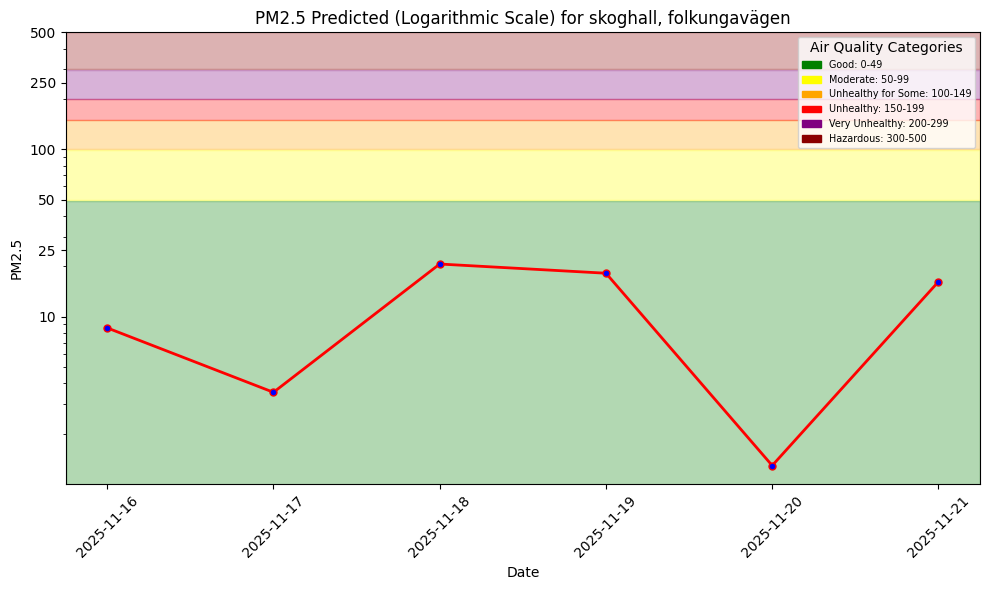

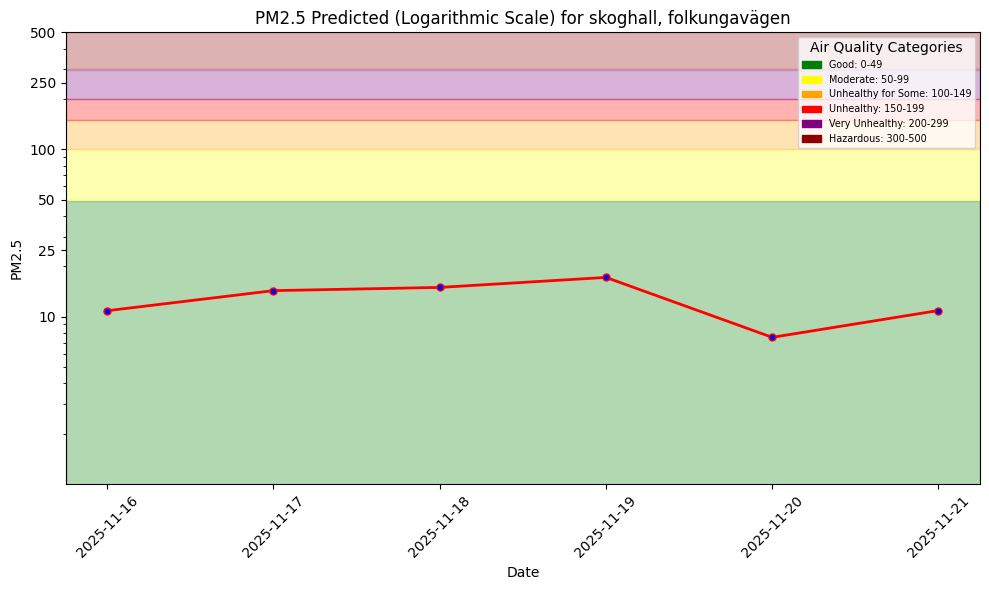

Uploading: 0.000%|          | 0/56038 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/46201 elapsed<00:00 remaining<?

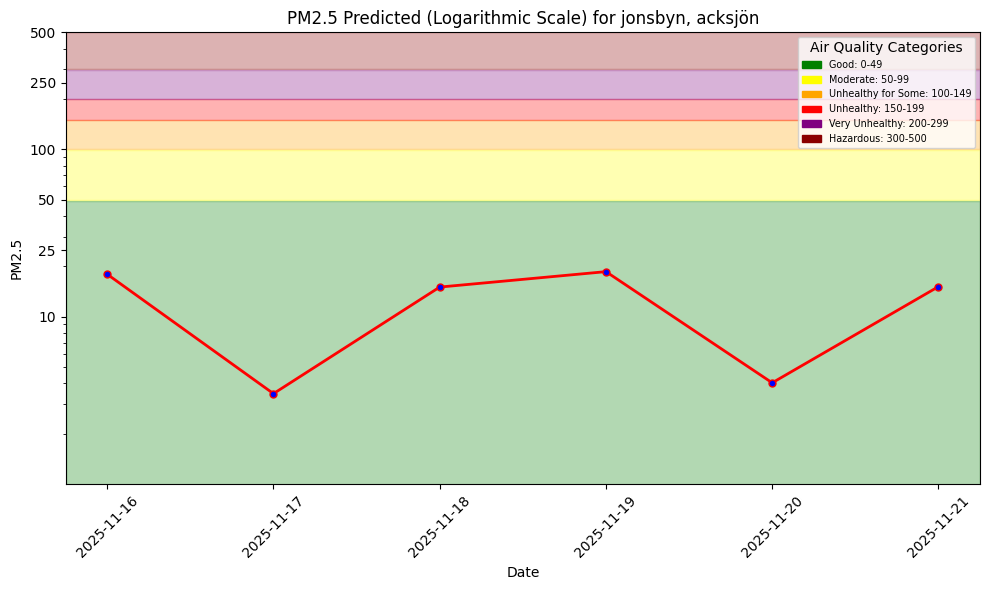

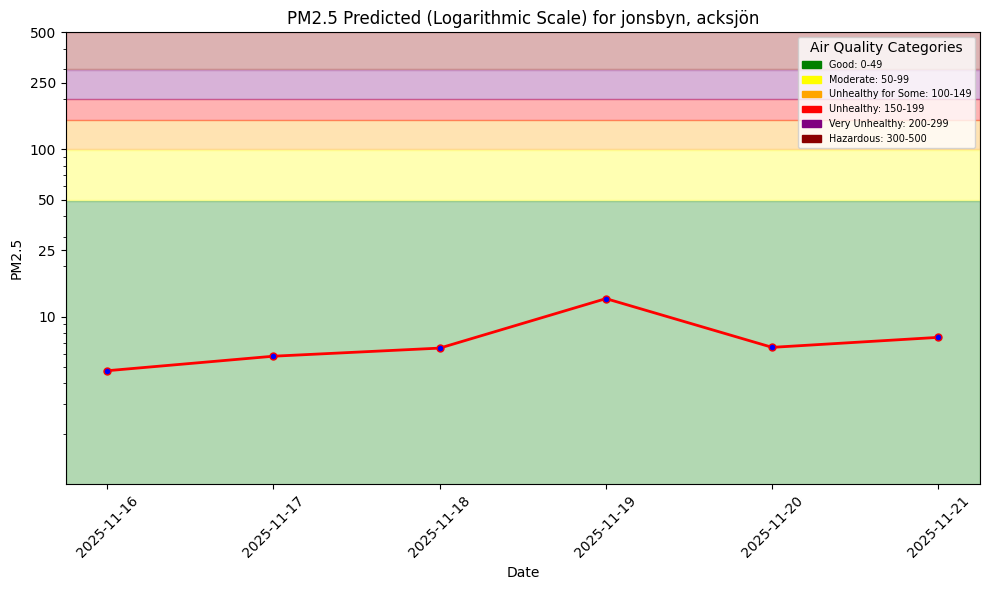

Uploading: 0.000%|          | 0/52541 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/45598 elapsed<00:00 remaining<?

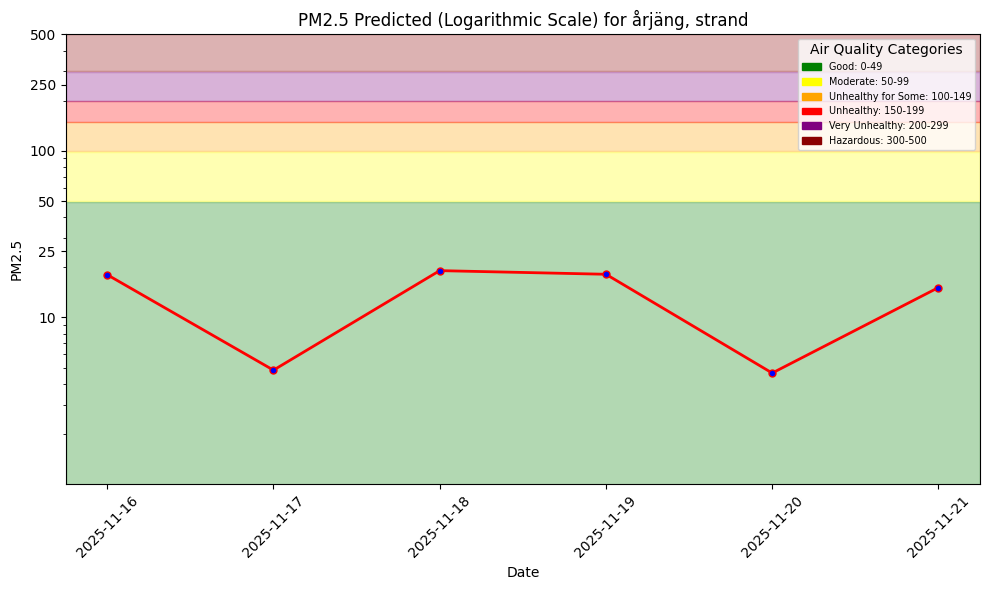

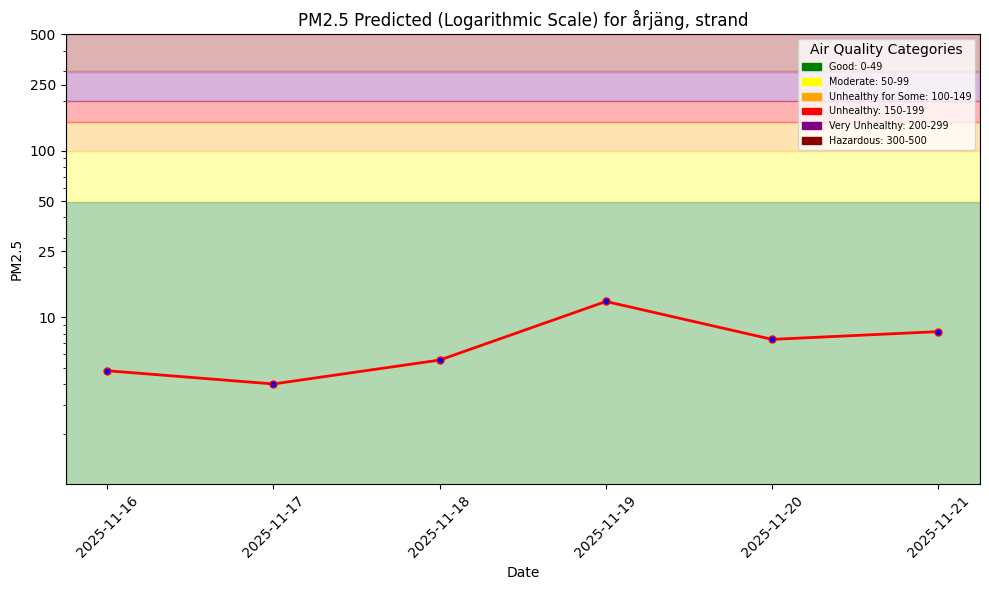

Uploading: 0.000%|          | 0/50500 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/45855 elapsed<00:00 remaining<?

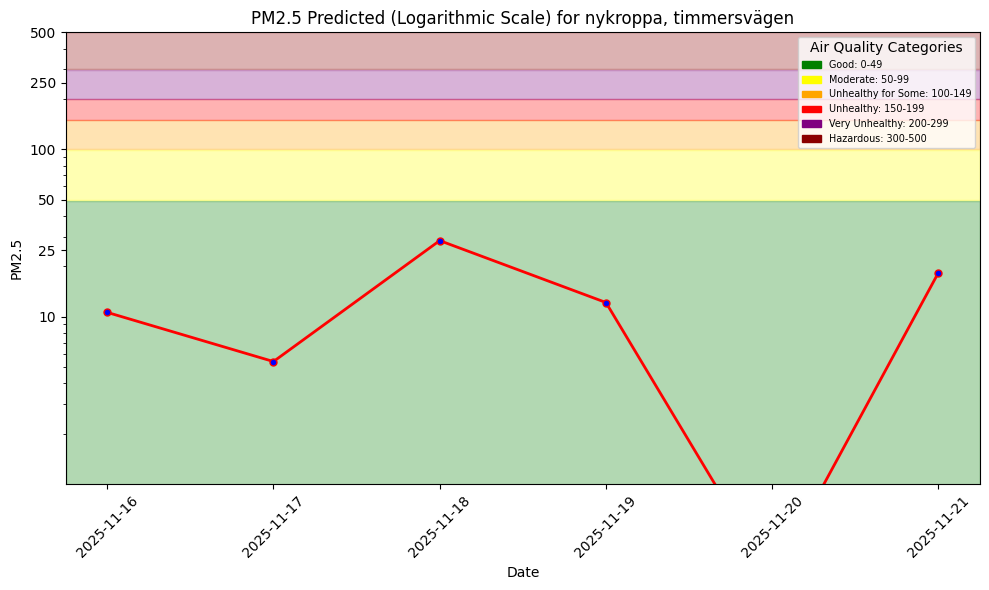

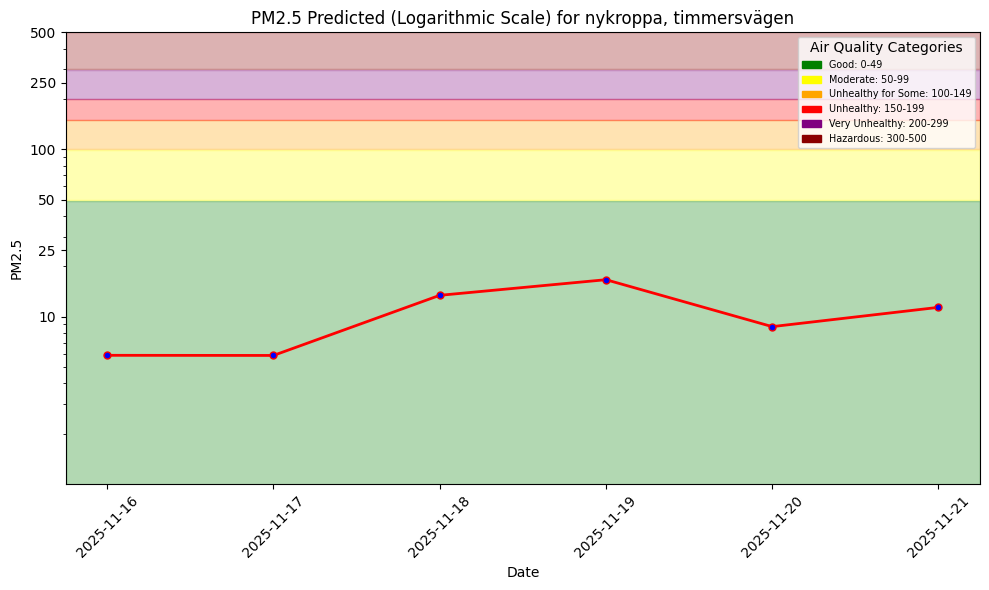

Uploading: 0.000%|          | 0/53263 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/47094 elapsed<00:00 remaining<?

In [16]:
for location in sensors_data:
    city = location['city']
    street = location['street']
    base_city_dir = f"{base_images_dir}/{city}"
    lagged_city_dir = f"{lagged_images_dir}/{city}"
    if not os.path.exists(base_city_dir):
        os.mkdir(base_city_dir)
    if not os.path.exists(lagged_city_dir):
        os.mkdir(lagged_city_dir)
    base_file_path = f"{base_city_dir}/pm25_forcast.png"
    lagged_file_path = f"{lagged_city_dir}/pm25_forcast_lagged.png"
    base_plt = util.plot_air_quality_forecast(city, street, air_quality_forecast_base[air_quality_forecast_base['city'] == city], base_file_path)
    lagged_plt = util.plot_air_quality_forecast(city, street, air_quality_forecast_lagged[air_quality_forecast_lagged['city'] == city], lagged_file_path)
    base_plt.show()
    lagged_plt.show()
    dataset_api.upload(base_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
    dataset_api.upload(lagged_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

In [17]:
monitor_fg_base = fs.get_or_create_feature_group(
    name='aq_predictions_base',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','country','days_before_forecast_day'],
    event_time="date"
)

monitor_fg_lagged = fs.get_or_create_feature_group(
    name='aq_predictions_lagged',
    description='Air Quality prediction monitoring (lagged)',
    version=1,
    primary_key=['city','street','country','days_before_forecast_day'],
    event_time="date"
)

In [18]:
monitor_fg_base.insert(air_quality_forecast_base)
monitor_fg_lagged.insert(air_quality_forecast_lagged, wait=True)

Uploading Dataframe: 100.00% |██████████| Rows 24/24 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_base_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1272014/jobs/named/aq_predictions_base_1_offline_fg_materialization/executions


Uploading Dataframe: 100.00% |██████████| Rows 24/24 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_lagged_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1272014/jobs/named/aq_predictions_lagged_1_offline_fg_materialization/executions
2025-11-15 12:27:59,070 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-15 12:28:02,289 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-15 12:29:54,985 INFO: Waiting for execution to finish. Current state: SUCCEEDING. Final status: UNDEFINED
2025-11-15 12:29:58,212 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-15 12:29:58,365 INFO: Waiting for log aggregation to finish.
2025-11-15 12:30:20,540 INFO: Execution finished successfully.


(Job('aq_predictions_lagged_1_offline_fg_materialization', 'SPARK'), None)

In [19]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_base = monitor_fg_base.filter(monitor_fg_base.days_before_forecast_day == 1).read()
monitoring_lagged = monitor_fg_lagged.filter(monitor_fg_lagged.days_before_forecast_day == 1).read()

air_quality_fg = fs.get_feature_group(name='air_quality', version=1)
air_quality_df = air_quality_fg.read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.05s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.71s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.32s) 


                       date  predicted_pm25      city  pm25  lagged_1  \
0 2025-11-15 00:00:00+00:00       27.187454  skoghall  10.0       3.0   
1 2025-11-15 00:00:00+00:00       22.868694    årjäng   3.0       2.0   
2 2025-11-15 00:00:00+00:00       15.081079  nykroppa   4.0       5.0   
3 2025-11-15 00:00:00+00:00       25.324059   jonsbyn   2.0       2.0   

   lagged_2   lagged_3 country         street  \
0       5.0  33.978001  sweden  folkungavägen   
1       3.0  14.700000  sweden         strand   
2       7.0  24.444000  sweden   timmersvägen   
3       6.0   4.620000  sweden        acksjön   

                                  url  
0  https://api.waqi.info/feed/A401314  
1   https://api.waqi.info/feed/A87319  
2  https://api.waqi.info/feed/A208483  
3  https://api.waqi.info/feed/A121810  


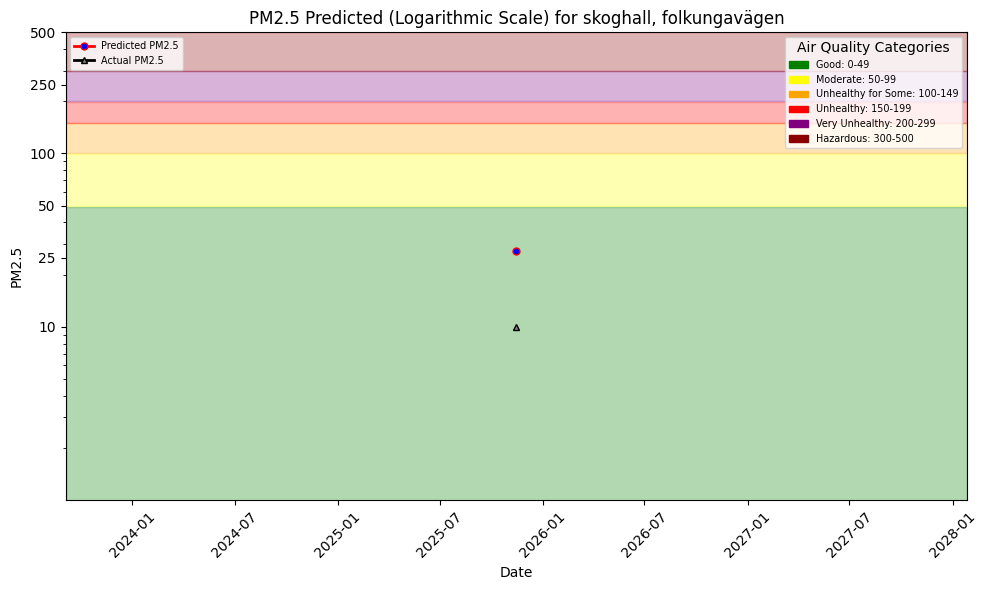

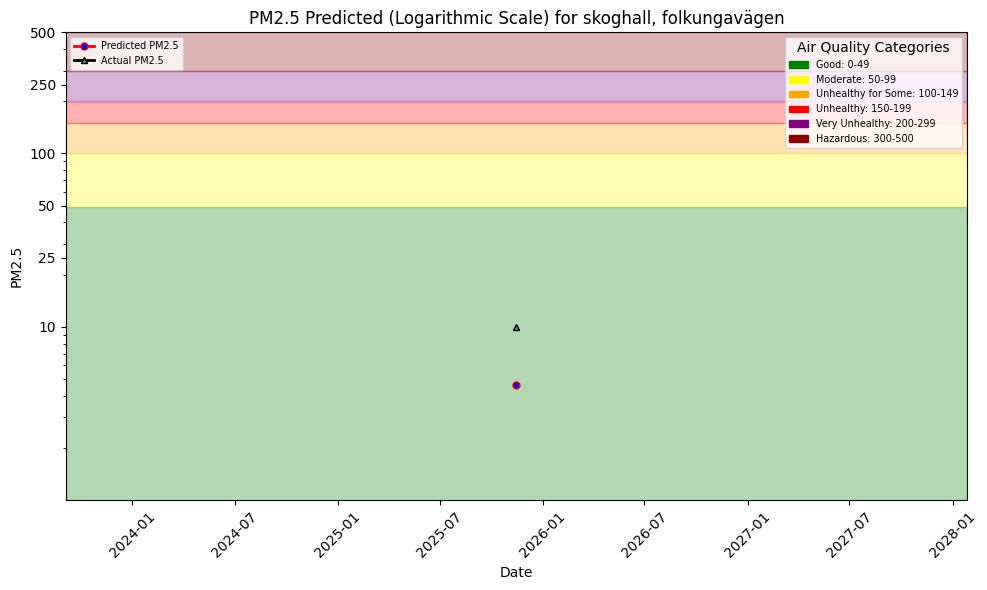

Uploading: 0.000%|          | 0/43543 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/43594 elapsed<00:00 remaining<?

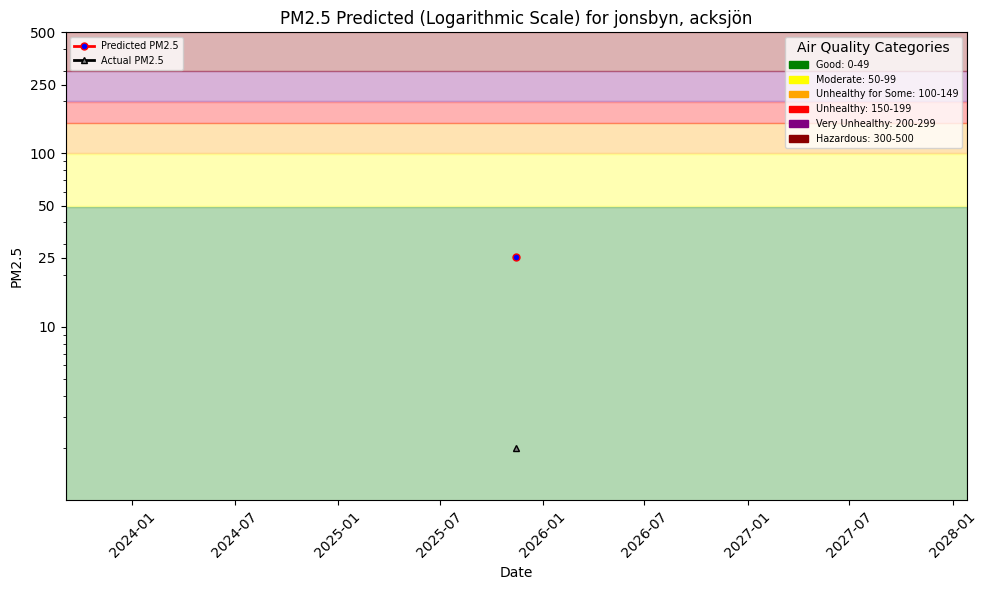

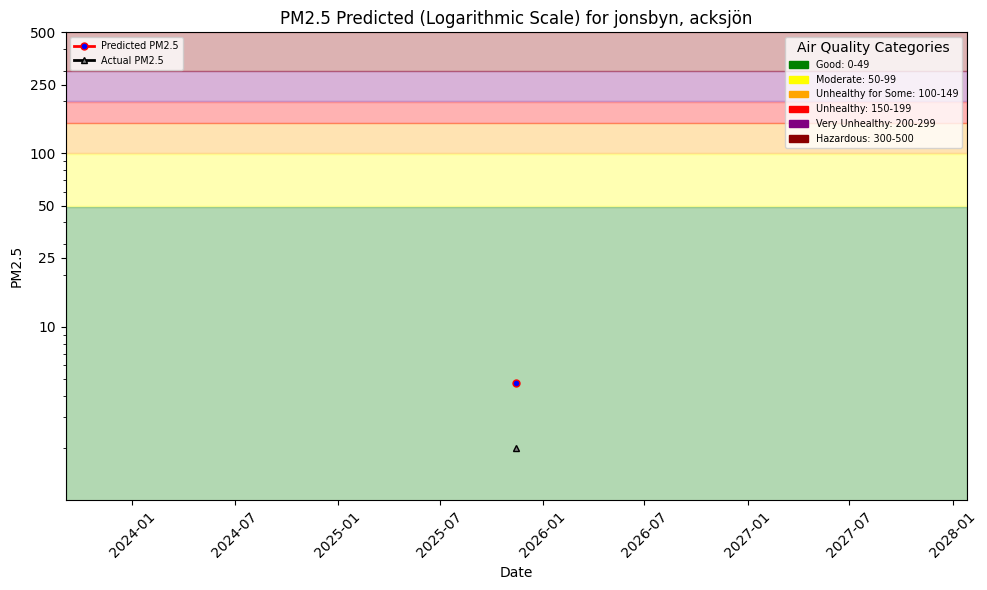

Uploading: 0.000%|          | 0/42735 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/42794 elapsed<00:00 remaining<?

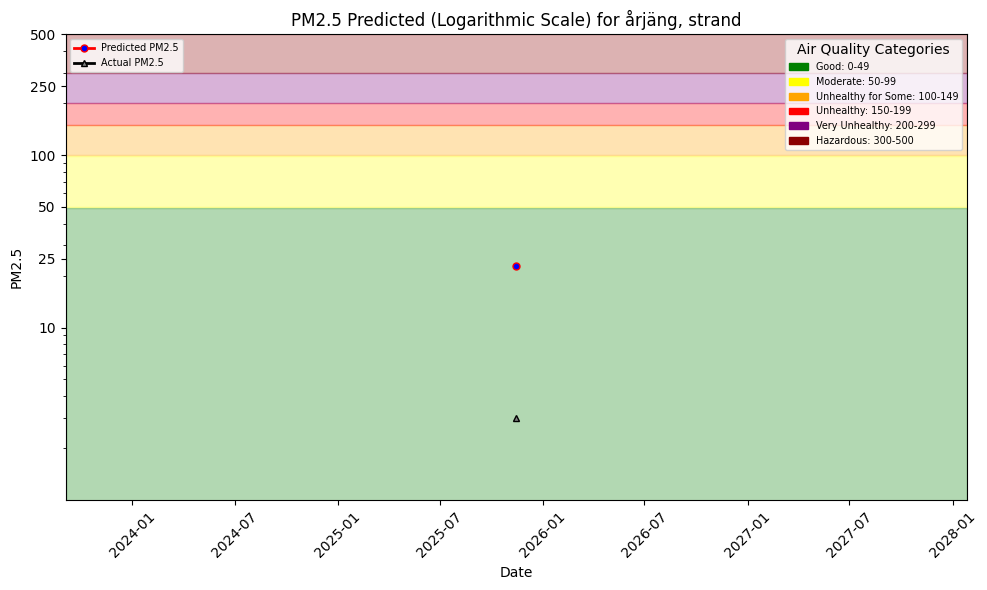

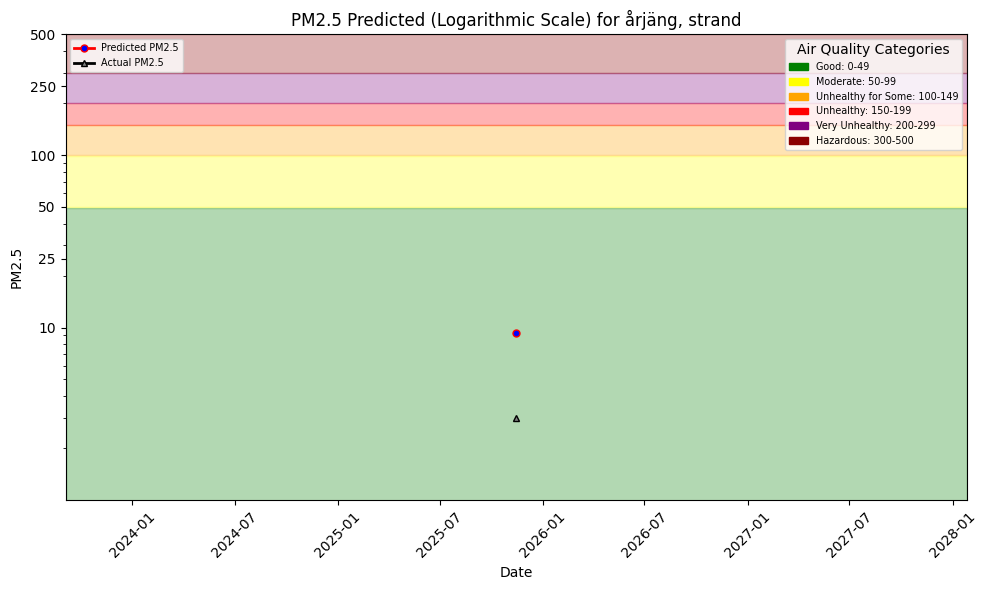

Uploading: 0.000%|          | 0/42150 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/42157 elapsed<00:00 remaining<?

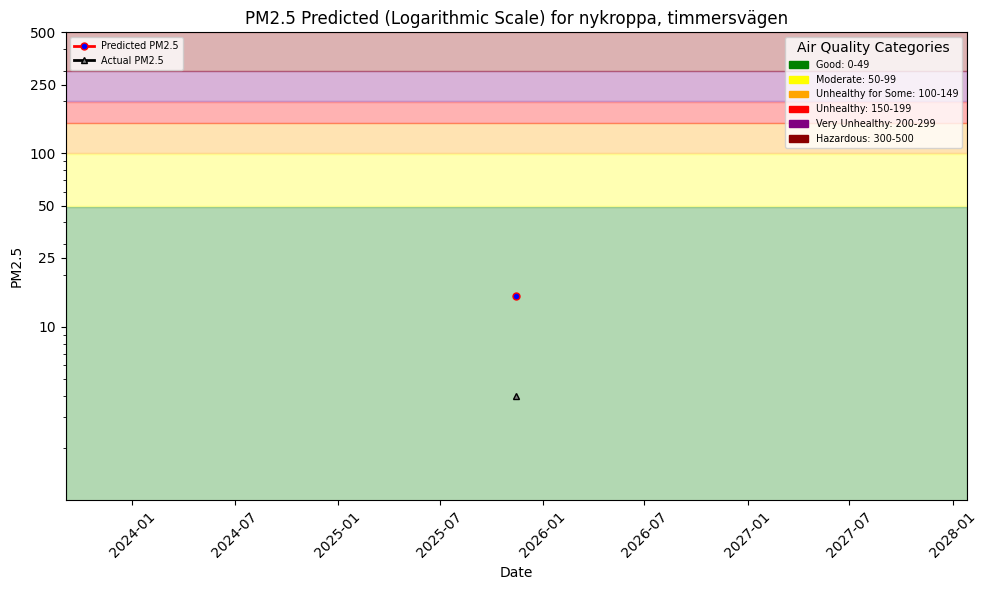

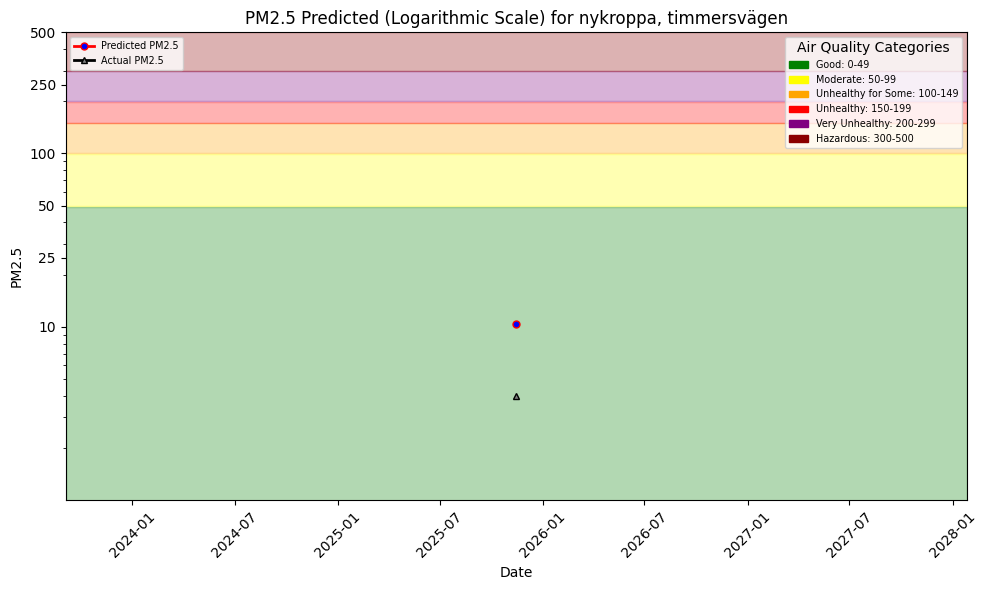

Uploading: 0.000%|          | 0/43818 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/43811 elapsed<00:00 remaining<?

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1272014/settings/fb/path/Resources/airquality


In [20]:
preds_base =  monitoring_base[['date', 'predicted_pm25', 'city']]
preds_lagged =  monitoring_lagged[['date', 'predicted_pm25', 'city']]

hindcast_base = pd.merge(preds_base, air_quality_df, on=["date", "city"])
hindcast_base = hindcast_base.sort_values(by=['date'])

hindcast_lagged = pd.merge(preds_lagged, air_quality_df, on=["date", "city"])
hindcast_lagged = hindcast_lagged.sort_values(by=['date'])

print(hindcast_base)

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
for location in sensors_data:
    city = location['city']
    street = location['street']
    hindcast_location_base = hindcast_base[hindcast_base['city'] == city]
    hindcast_location_lagged = hindcast_lagged[hindcast_lagged['city'] == city]
    base_hindcast_path = f"{base_city_dir}/pm25_hindcast.png"
    lagged_hindcast_path = f"{lagged_city_dir}/pm25_hindcast_lagged.png"
    base_plt = util.plot_air_quality_forecast(city, street, hindcast_location_base, base_hindcast_path, hindcast=True)
    lagged_plt = util.plot_air_quality_forecast(city, street, hindcast_location_lagged, lagged_hindcast_path, hindcast=True)
    base_plt.show()
    lagged_plt.show()
    dataset_api.upload(base_hindcast_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
    dataset_api.upload(lagged_hindcast_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")